# Rekko challenge 2019

```
                           /$$$$$$$  /$$$$$$$$ /$$   /$$ /$$   /$$  /$$$$$$ 
                          | $$__  $$| $$_____/| $$  /$$/| $$  /$$/ /$$__  $$
                          | $$  \ $$| $$      | $$ /$$/ | $$ /$$/ | $$  \ $$
                          | $$$$$$$/| $$$$$   | $$$$$/  | $$$$$/  | $$  | $$
                          | $$__  $$| $$__/   | $$  $$  | $$  $$  | $$  | $$
                          | $$  \ $$| $$      | $$\  $$ | $$\  $$ | $$  | $$
                          | $$  | $$| $$$$$$$$| $$ \  $$| $$ \  $$|  $$$$$$/
                          |__/  |__/|________/|__/  \__/|__/  \__/ \______/ 
                                                                            
```

Добро пожаловать на соревнование по машинному обучению от онлайн-кинотеатра [Okko](http://okko.tv) Rekko Challenge 2019.

В этом ноутбуке мы покажем вам пример простого но полного решения, от загрузки данных до формирования ответа. Для работы нам понадобятся библиотеки `pandas`, `numpy`, `scipy`, `implicit`, `pprint`, `tqdm`. Установить их в вашем рабочем окружении можно следующей командой.
```
pip install pandas numpy scipy implicit pprint tqdm
```

In [18]:
import os
import json
import pandas as pd
import numpy as np
import tqdm
import scipy.sparse as sp
import seaborn as sns
import matplotlib as plt 
%matplotlib inline

from pprint import pprint

### Загрузка данных

Замените `DATA_PATH` на путь к данным, которые вы скачали со страницы соревнования.

In [2]:
DATA_PATH = './'

---

`catalogue.json` содержит анонимизированную метаинформацию о доступных в сервисе фильмах и сериалах.

In [10]:
with open(os.path.join(DATA_PATH, 'catalogue.json'), 'r') as f:
    catalogue = json.load(f)

type(catalogue)
catalogue = {int(k): v for k, v in catalogue.items()}

In [11]:
len(catalogue)

10200

In [13]:
pprint(catalogue[0])

{'attributes': [31115, 6713, 10906, 31116, 31117, 270, 24431, 42, 31118, 31119],
 'availability': [],
 'duration': 80,
 'feature_1': 29121982.214158818,
 'feature_2': 0.5752595062,
 'feature_3': 0,
 'feature_4': 1.1283323575,
 'feature_5': 0.6547073468,
 'type': 'movie'}


 - `attributes` — мешок атрибутов
 - `availability` — доступность (может содержать значения `purchase`, `rent` и `subscription`)
 - `duration` — длительность в минутах, округлённая до десятков (продолжительность серии для сериалов и многосерийных фильмов)
 - `feature_1..5` — пять анонимизированных вещественных и порядковых признаков
 - `type` — принимает значения `movie`, `multipart_movie` или `series`

---

`test_users.json` содержит список пользователей, для которых необходимо построить предсказание

In [14]:
with open(os.path.join(DATA_PATH, 'test_users.json'), 'r') as f:
    test_users = set(json.load(f)['users'])

---

`transactions.csv` — список всех транзакций за определённый период времени

In [15]:
%%time
transactions = pd.read_csv(
    os.path.join(DATA_PATH, 'transactions.csv'),
    dtype={
        'element_uid': np.uint16,
        'user_uid': np.uint32,
        'consumption_mode': 'category',
        'ts': np.float64,
        'watched_time': np.uint64,
        'device_type': np.uint8,
        'device_manufacturer': np.uint8
    }
)

Wall time: 10 s


In [16]:
transactions.head(3)

,element_uid,user_uid,consumption_mode,ts,watched_time,device_type,device_manufacturer
0,3336,5177,S,4.430518e+07,4282,0,50
1,481,593316,S,4.430518e+07,2989,0,11
2,4128,262355,S,4.430518e+07,833,0,50


 - `element_uid` — идентификатор элемента
 - `user_uid` — идентификатор пользователя
 - `consumption_mode` — тип потребления (`P` — покупка, `R` — аренда, `S` — просмотр по подписке)
 - `ts` — время совершения транзакции или начала просмотра в случае просмотра по подписке
 - `watched_time` — число просмотренных по транзакции секунд
 - `device_type` — анонимизированный тип устройства, с которого была совершена транзакция или начат просмотр
 - `device_manufacturer` — анонимизированный производитель устройства, с которого была совершена транзакция или начат просмотр

In [17]:
transactions.describe()

,element_uid,user_uid,ts,watched_time,device_type,device_manufacturer
count,9.643012e+06,9.643012e+06,9.643012e+06,9.643012e+06,9.643012e+06,9.643012e+06
mean,4.903627e+03,2.972156e+05,4.308295e+07,6.338216e+03,7.113436e-01,5.378050e+01
std,2.962026e+03,1.710970e+05,7.459096e+05,1.823438e+04,1.523222e+00,3.064894e+01
min,0.000000e+00,0.000000e+00,4.173063e+07,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.332000e+03,1.489950e+05,4.243755e+07,9.780000e+02,0.000000e+00,5.000000e+01
50%,4.661000e+03,2.973630e+05,4.314893e+07,4.959000e+03,0.000000e+00,5.000000e+01
75%,7.433000e+03,4.453270e+05,4.372865e+07,6.446000e+03,0.000000e+00,9.000000e+01
max,1.019900e+04,5.934890e+05,4.430518e+07,4.326296e+06,6.000000e+00,9.900000e+01


---

C:\Users\nord2\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


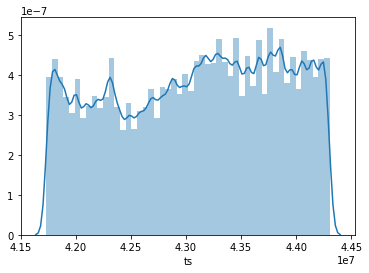

In [21]:
sns.distplot(transactions['ts'])

In [ ]:
sns.distplot([])

`ratings.csv` содержит информацию о поставленных пользователями оценках

In [37]:
%%time
ratings = pd.read_csv(
    os.path.join(DATA_PATH, 'ratings.csv'),
    dtype={
        'element_uid': np.uint16,
        'user_uid': np.uint32,
        'ts': np.float64,
        'rating': np.uint8
    }
)

Wall time: 386 ms


In [38]:
ratings.head(3)

,user_uid,element_uid,rating,ts
0,571252,1364,10,4.430517e+07
1,63140,3037,10,4.430514e+07
2,443817,4363,8,4.430514e+07


 - `rating` — поставленный пользователем рейтинг (от `0` до `10`)

---

In [39]:
ratings.describe()

,user_uid,element_uid,rating,ts
count,438790.000000,438790.000000,438790.000000,4.387900e+05
mean,297633.918918,4877.467467,8.189079,4.298166e+07
std,170411.749934,2952.994260,2.074550,7.275682e+05
min,1.000000,3.000000,0.000000,4.173065e+07
25%,147598.000000,2297.000000,7.000000,4.232747e+07
50%,300425.000000,4709.000000,9.000000,4.301707e+07
75%,445190.000000,7381.000000,10.000000,4.358960e+07
max,593486.000000,10199.000000,10.000000,4.430517e+07


`bookmarks.csv` содержит информацию об элементах, добавленных пользователями в список «Избранное»

In [40]:
%%time
bookmarks = pd.read_csv(
    os.path.join(DATA_PATH, 'bookmarks.csv'),
    dtype={
        'element_uid': np.uint16,
        'user_uid': np.uint32,
        'ts': np.float64
    }
)

Wall time: 617 ms


In [41]:
bookmarks.head(3)

,user_uid,element_uid,ts
0,301135,7185,4.430516e+07
1,301135,4083,4.430516e+07
2,301135,10158,4.430516e+07


### Решение

Для начала построим список элементов, которые тестовые пользователи уже купили или посмотрели по подписке: они не смогут купить их второй раз, а просмотр по подписке второй раз маловероятен, поэтому мы захотим отфильтровать такие элементы из финального ответа.

Точно так же можно поступить и с рейтингами и добавлениями в избранное, если это будет казаться правильным.

In [42]:
from collections import defaultdict

filtered_elements = defaultdict(set)

for user_uid, element_uid in tqdm.tqdm(transactions.loc[:, ['user_uid', 'element_uid']].values):
    if user_uid not in test_users:
        continue
    filtered_elements[user_uid].add(element_uid)

100%|████████████████████████████████████████████████████████████████████| 9643012/9643012 [00:16<00:00, 569247.75it/s]


---

Для примера мы воспользуемся методом K ближайших соседей, реализованным в библиотеке `implicit`. В качестве данных используем только информацию о рейтингах.

Необходимо построить разреженную матрицу, где строкам будут соответствовать элементы, столбцам — пользователи, а на пересечении пользователя и элемента будет находиться количественная оценка степени их взаимодействия, если таковое имело место.

Не забудем добавить `1` к рейтингу, чтобы избежать деления на ноль во время вычисления `tf-idf`.

In [47]:
ratings['user_uid'] = ratings['user_uid'].astype('category')
ratings['element_uid'] = ratings['element_uid'].astype('category')
ratings['user_uid'].cat.codes

0         100665
1          11080
2          78162
3          63340
4          63340
5          98358
6          40587
7          16904
8           2988
9           6306
10         30551
11         72474
12         49414
13         57646
14         73871
15         32515
16         19580
17          8348
18         76399
19         10319
20          2279
21         64673
22          2208
23         74010
24         83974
25         14301
26          6052
27         17462
28          6261
29          9961
           ...  
438760     20988
438761     81092
438762     17135
438763     99742
438764     80312
438765     32592
438766     59336
438767     98976
438768     84511
438769      4140
438770      9809
438771      9868
438772     17009
438773     35478
438774    100352
438775     95406
438776    102277
438777     99173
438778     92670
438779     50454
438780     91275
438781     58072
438782     50778
438783     18383
438784     97835
438785     30028
438786      5710
438787     622

In [43]:
ratings['user_uid'] = ratings['user_uid'].astype('category')
ratings['element_uid'] = ratings['element_uid'].astype('category')
ratings['user_uid'].cat.categories()

ratings_matrix = sp.coo_matrix(
    (ratings['rating'].astype(np.float32) + 1,
        (
            ratings['element_uid'].cat.codes.copy(),
            ratings['user_uid'].cat.codes.copy()
        )
    )
)

ratings_matrix = ratings_matrix.tocsr()

TypeError: 'UInt64Index' object is not callable

In [17]:
sparsity = ratings_matrix.nnz / (ratings_matrix.shape[0] * ratings_matrix.shape[1])
print('Sparsity: %.6f' % sparsity)

Sparsity: 0.000558


Обучить модель крайне просто.

In [18]:
from implicit.nearest_neighbours import TFIDFRecommender

model = TFIDFRecommender()
model.fit(ratings_matrix)

100%|███████████████████████████████████████████████████████████████████████████| 7519/7519 [00:00<00:00, 89751.50it/s]


---

In [17]:
ratings_matrix_T = ratings_matrix.T.tocsr()

Отображения из оригинальной категории во внутреннюю пригодится нам в дальнейшем.

In [18]:
user_uid_to_cat = dict(zip(
    ratings['user_uid'].cat.categories,
    range(len(ratings['user_uid'].cat.categories))
))

In [19]:
element_uid_to_cat = dict(zip(
    ratings['element_uid'].cat.categories,
    range(len(ratings['element_uid'].cat.categories))
))

In [20]:
filtered_elements_cat = {k: [element_uid_to_cat.get(x, None) for x in v] for k, v in filtered_elements.items()}

---

В метод `model.recommend` мы передаём идентификатор пользователя, который получаем обратным преобразованием из категории, транспонированную матрицу взаимодействий, число необходимых рекомендаций и список элементов, которые мы договорились фильтровать из ответа.

Возвращает метод список пар (`element_cat`, `score`), отсортированный по вторым элементам. Из него необходимо достать все первые элементы пар и из категории преобразовать их к `element_uid`.

**Важно:** Не все тестовые пользователи есть в `ratings.csv` и не все из них есть в `transactions.csv`. Используя только один источник данных мы не можем построить полное предсказание. Такой ответ с неполным числом пользователей бдет принят системой, но при вычислении средней метрики метрика для отсутствующих пользователей будет принята равной нулю.

In [21]:
result = {}

for user_uid in tqdm.tqdm(test_users):
    # transform user_uid to model's internal user category
    try:
        user_cat = user_uid_to_cat[user_uid]
    except LookupError:
        continue
    
    # perform inference
    recs = model.recommend(
        user_cat,
        ratings_matrix_T,
        N=20,
        filter_already_liked_items=True,
        filter_items=filtered_elements_cat.get(user_uid, set())
    )
    
    # drop scores and transform model's internal elelemnt category to element_uid for every prediction
    # also convert np.uint64 to int so it could be json serialized later
    result[user_uid] = [int(ratings['element_uid'].cat.categories[i]) for i, _ in recs]

100%|██████████| 50000/50000 [00:01<00:00, 27307.04it/s]


In [22]:
len(result)

13251

Используя только информацию о рейтингах мы смогли построить предсказание для `13251` из `50000` тестовых пользователей. Ровно в таком виде ответы и стоит сохранить для отправки.

In [23]:
with open('answer.json', 'w') as f:
    json.dump(result, f)